# Multi-Agent Path Finding (MAPF)

In this lab we consider the problem of finding a set of collision-free paths for a group of agents. The environment is represented by a grid composed of the free and blocked cells. All the agents are homogenous and each of them have their own unique start and goal locations.

For simplicity it's assumed that agents can perform cardinal-only moves. They can also perform a wait action. All the actions have equal duration, so it's possible to discretize the timeline saying that at each time step the agent can either move to one of the cardinal-adjacent cells or to stay in the same cell performing a wait-action.

The search-space state is described by tuple `<i, j, t>` where `i` and `j` are the cell's coordinates, `t` - time moment. So now theoretically there are an inifinite number of states corresponding to the same grid cell.

Your task is to solve MAPF-problem, implementing two different approaches:
1) Prioritized approach. Fast, not optimal, incomplete.\
2) Conflict-based search (CBS) algorithm. Slow, optimal, solution-complete.

You can reuse the previosly implemented A* with timesteps algorithm.
Using the given instances you need to validate the correctness of your implementations.

<img src="Image/example.gif" width="350" align="center">

In [75]:
from PIL import Image, ImageDraw
from IPython.display import Image as Img
import matplotlib.pyplot as plt
from heapq import heappop, heappush
from random import randint
import time
import math
%matplotlib notebook

In [76]:
'''Grid'''
class Map:

    # 
    def __init__(self):
        '''
        Default constructor
        '''

        self.width = 0
        self.height = 0
        self.cells = []
    

    def ReadFromString(self, cellStr, width, height):
        '''
        Converting a string (with '#' representing obstacles and '.' representing free cells) to a grid
        '''
        self.width = width
        self.height = height
        self.cells = [[0 for _ in range(width)] for _ in range(height)]
        cellLines = cellStr.split("\n")
        i = 0
        j = 0
        for l in cellLines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c == '.':
                        self.cells[i][j] = 0
                    elif c == '#':
                        self.cells[i][j] = 1
                    else:
                        continue
                    j += 1
                if j != width:
                    raise Exception("Size Error. Map width = ", j, ", but must be", width )
                
                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height )
    
     
    def SetGridCells(self, width, height, gridCells):
        '''
        Initialization of map by list of cells.
        '''
        self.width = width
        self.height = height
        self.cells = gridCells


    def inBounds(self, i, j):
        '''
        Check if the cell is on a grid.
        '''
        return (0 <= j < self.width) and (0 <= i < self.height)
    

    def Traversable(self, i, j):
        '''
        Check if the cell is not an obstacle.
        '''
        return not self.cells[i][j]


    def GetNeighbors(self, i, j):
      neighbors = []

      for di in range(-1, 2):
        for dj in range(-1, 2):
          if di*dj == 0 and self.inBounds(i+di, j+dj) and self.Traversable(i+di, j+dj):
            neighbors.append((i+di, j+dj))
      
      return neighbors

In [95]:
class Node:
    '''
    Node class represents a search node

    - i, j: coordinates of corresponding grid element
    - g: g-value of the node 
    - h: h-value of the node
    - F: f-value of the node
    - parent: pointer to the parent-node 

    You might want to add other fields, methods for Node, depending on how you prefer to implement OPEN/CLOSED further on
    '''

    def __init__(self, coord, g = 0, h = 0, F = None, parent = None):
        self.i = int(coord[0])
        self.j = int(coord[1])
        self.g = g #equals t
        self.h = h
        if F is None:
            self.F = self.g + h
        else:
            self.F = F        
        self.parent = parent
    
    def __str__(self):
      return ' '.join((str(self.i), str(self.j)))
    # def __eq__(self, other):
    #     return (self.i == other.i) and (self.j == other.j) and (self.g == other.g)
    
    def __lt__(self, other): #self < other (self has higher priority)
        return self.F < other.F or (self.F == other.F and (self.g > other.g))

In [78]:
import heapq as hq

class Open:
    '''
    !!!TODO!!!
    Create your own modification of OPEN#
    '''

    def __init__(self):
        self.elements = []
        self.indexes = {}


    def __iter__(self):
        return iter(self.elements)


    def __len__(self):
        return len(self.elements)


    def isEmpty(self):
        if len(self.elements) != 0:
            return False
        return True



    def AddNode(self, newNode : Node):
        
        if self.indexes.get((newNode.i, newNode.j, newNode.g)):
          existingNode = self.indexes[(newNode.i, newNode.j, newNode.g)]
          if existingNode.F > newNode.F:
            existingNode.g = newNode.g
            existingNode.F = newNode.F
            existingNode.parent = newNode.parent
            self.indexes[(newNode.i, newNode.j, newNode.g)] = existingNode
            hq.heappush(self.elements, (newNode.F, newNode))
            return
          else:

            return


        self.indexes[(newNode.i, newNode.j, newNode.g)] = newNode
        hq.heappush(self.elements, (newNode.F, newNode))

    def GetBestNode(self, *args):
      
      return hq.heappop(self.elements)[1]

In [79]:
class Closed:

    def __init__(self):
        self.elements = {}


    def __iter__(self):
        return iter(self.elements.values())
    

    def __len__(self):
        return len(self.elements)


    def AddNode(self, item : Node):
        self.elements[(item.i, item.j, item.g)] = item


    def WasExpanded(self, item : Node):
        return self.elements.get((item.i, item.j, item.g))

In [80]:
class CT_Node:
    '''
    CT_Node is a structure that stores a single alternative solution generated by CBS
    during the search process.
    Each CT-node has ID, cost, a set of paths, a set of constraints
    To speed up CBS a bit, CT-nodes need to have proper breaking ties besides cost. It's better to prefer nodes with less conflicts. 
    In case of equal cost and numbers of conflicts, you can try to use some other criterion. For example, the amount of imposed constraints.
    '''
    def __init__(self, agentID=None, paths=[], cost=0, constraint=None, conflicts = [], cons_num = 0, parent=None):
        self.id = ""
        self.replannedAgentID = agentID
        self.paths = paths
        self.cost = cost
        self.constraint = constraint
        self.parent = parent
        self.conflicts = conflicts
        self.cons_num = cons_num
        
    def __lt__(self, other):
        if self.cost < other.cost or (self.cost == other.cost and len(self.conflicts) < len(other.conflicts)) or (self.cost == other.cost and len(self.conflicts) == len(other.conflicts) and self.cons_num > other.cons_num):
            return True
        return False
    
class CT_Tree:
    '''
    CT_Tree is a structure that stores all the generated CT-nodes(alternative solutions)
    It also can return current best CT-node
    '''
    def __init__(self):
        self.nodes = []
        self.open = []
        
    def GetBestNode(self):
        return heappop(self.open)
    
    def AddNode(self, ct_node):
        self.nodes.append(ct_node)
        heappush(self.open, ct_node)

class constraint:
    '''
    Constraint class represents a CBS constraint
    There are two types of constraints: edge and vertex constraint
    In case if it's a vertex constraint, it forbids to occupy some cell in the exact time moment
    In case if it's an edge constraint, it forbids to move along some edge
    '''
    def __init__(self, agentID, i1, j1, i2, j2, t, con_type):
        self.agentID = agentID
        self.i1 = i1
        self.j1 = j1
        self.i2 = i2
        self.j2 = j2
        self.t = t
        self.type = con_type

class agent:
    '''
    Agent class stores the information about one agent, i.e.
    its id and the coordinates of start and goal locations
    '''
    def __init__(self, ID, iStart, jStart, iGoal, jGoal):
        self.id = ID
        self.iStart = iStart
        self.jStart = jStart
        self.iGoal = iGoal
        self.jGoal = jGoal

In [81]:
def ManhattanDistance(i1, j1, i2, j2):
    return abs(i1 - i2) + abs(j1 - j2)

In [82]:
def MakePath(goal):
    '''
    Creates a path by tracing parent pointers from the goal node to the start node
    It also returns path's length.
    '''

    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [83]:
class AstarTimesteps:
    def __init__(self, gridMap, iStart, jStart, iGoal, jGoal, obstacles=[], constraints=[]):
        self.obstacles = obstacles
        self.constraints = constraints
        self.gridMap = gridMap
        self.iStart = iStart
        self.jStart = jStart
        self.iGoal = iGoal
        self.jGoal = jGoal
        self.OPEN = Open()
        self.CLOSED = Closed()
        self.path = []
        
    def CheckMove(self, i1, j1, i2, j2, t):
      for obst in self.obstacles:
        if t < len(obst):
          if obst[t] == (i2, j2):
            return False
          if obst[t] == (i1,j1) and obst[t-1] == (i2, j2):
            return False
        elif obst[-1] == (i2,j2):
          return False
      return True
    
    def CheckGoal(self, t):
      for obst in self.obstacles:
        for _t in range(t, len(obst)):
          if obst[_t] == (self.iGoal, self.jGoal):
            return False
      return True

    
    def FindPath(self):
      start = Node((self.iStart,self.jStart))
      start.h = ManhattanDistance(self.iStart, self.jStart, self.iGoal, self.jGoal)
      start.F = start.h
      self.OPEN.AddNode(start)


      while not self.OPEN.isEmpty() :
        curNode = self.OPEN.GetBestNode()
        # print(curNode.i, curNode.j)
        if curNode.i == self.iGoal and curNode.j == self.jGoal:
          if self.CheckGoal(curNode.g):
            return (True, curNode, self.CLOSED, self.OPEN)
          else:
            self.CLOSED.AddNode(curNode)

        neighbors = self.gridMap.GetNeighbors(curNode.i, curNode.j)
        # print(neighbors)
        if neighbors:
          for node in neighbors:
            newNode = Node(node, g = curNode.g + 1)
            if not self.CLOSED.WasExpanded(newNode):
              if self.CheckMove(curNode.i, curNode.j, newNode.i, newNode.j, newNode.g):
                newNode.h = ManhattanDistance(newNode.i, newNode.j, self.iGoal, self.jGoal)
                newNode.F = newNode.g + newNode.h
                newNode.parent = curNode
                self.OPEN.AddNode(newNode) 

        self.CLOSED.AddNode(curNode)

      return (False, None, self.CLOSED, self.OPEN)

In [101]:
class Prioritized:
    def __init__(self, gridMap = None, agents = None):
        self.gridMap = gridMap
        self.agents = agents
        self.priorities = [i for i in range(len(agents))]
    
    def solve(self, timelimit = math.inf):
        start = time.time()
        obstacles = []
        paths = []
        total_cost = 0
        for i in self.priorities:
          astar = AstarTimesteps(self.gridMap, self.agents[i].iStart, self.agents[i].jStart, self.agents[i].iGoal, self.agents[i].jGoal, obstacles)
          result = astar.FindPath()
          
          path, cost = MakePath(result[1])
          paths.append(path)
          obstacle = []
          for point in path:
            obstacle.append((point.i, point.j))
          obstacles.append(obstacle)
          total_cost += cost

        return True, paths, total_cost, 1, time.time() - start
        

In [85]:
class CBS:
    def __init__(self, gridMap = None, agents = None):
        self.gridMap = gridMap
        self.agents = agents
        self.tree = CT_Tree()
        initial_solution = CT_Node()
        initial_solution.paths = []
#TODO (extra)
        self.tree.AddNode(initial_solution)
    
    def solve(self, timelimit = math.inf):
        start = time.time()
#TODO (extra)
            if time.time() - start > timelimit:
                return False, [], math.inf, len(self.tree.nodes) - len(self.tree.open), time.time() - start
                        
    def updateConflicts(self, conflicts, paths, j, pathB):
        updConflicts = []
#TODO (extra)
        return updConflicts
        
    def getConstraints(self, conflict, agent, ct_node):
#TODO (extra)
        return constraints
        
    def getPaths(self, ct_node):
#TODO (extra)
        return paths
        

IndentationError: ignored

In [ ]:
def Draw(gridMap : Map, paths : list, filename = 'animated_trajectories'):
    '''
    Auxiliary function that visualizes the enviromnet, the path and OPEN and CLOSED.
    '''
    k = 25
    quality = 5
    hIm = gridMap.height * k
    wIm = gridMap.width * k
    maxlen = 0
    for path in paths:
        maxlen = max(maxlen, len(path))
    step = 0
    images = []
    colors = [(randint(0,255), randint(0,255), randint(0,255)) for _ in range(len(paths))]
    while step < maxlen:
        for n in range(0, quality):
            im = Image.new('RGB', (wIm, hIm), color = 'white')
            draw = ImageDraw.Draw(im)
            for i in range(gridMap.height):
                for j in range(gridMap.width):
                    if(gridMap.cells[i][j] == 1):
                        draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=( 70, 80, 80 ))
            for i in range(len(paths)):
                curNode = paths[i][min(len(paths[i]) - 1, step)]
                nextNode = paths[i][min(len(paths[i]) - 1, step + min(n, 1))]
                draw.ellipse((float(curNode.j + n*(nextNode.j - curNode.j)/quality + 0.2) * k, 
                              float(curNode.i + n*(nextNode.i - curNode.i)/quality + 0.2) * k, 
                              float(curNode.j + n*(nextNode.j - curNode.j)/quality + 0.8) * k - 1, 
                              float(curNode.i + n*(nextNode.i - curNode.i)/quality + 0.8) * k - 1), 
                              fill=(colors[i][0], colors[i][1], colors[i][2]), width=0)
            images.append(im)
        step += 1
    images[0].save('./'+filename+'.gif.png', save_all=True, append_images=images[1:], optimize=False, duration=500/quality, loop=0)

In [ ]:
instances = []

height = 4
width = 11
mapstr = '''
###########
#####.#####
#.........#
###########
'''
taskMap = Map()
taskMap.ReadFromString(mapstr, width, height)
instances.append({'map':taskMap,'agents':[agent(0, 2, 1, 2, 9), agent(1, 2, 9, 2, 1)]})

height = 10
width = 10
mapstr = '''
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
'''

taskMap = Map()
taskMap.ReadFromString(mapstr, width, height)
instances.append({'map':taskMap,'agents':[agent(0, 1, 1, 5, 5), agent(1, 2, 2, 7, 0), agent(2, 0, 5, 3, 9), agent(3, 1, 7, 3, 2), agent(4, 6, 3, 9, 0)]})
instances.append({'map':taskMap,'agents':[agent(0, 1, 1, 5, 5), agent(1, 2, 2, 7, 0), agent(2, 0, 5, 3, 9), agent(3, 1, 7, 3, 2), agent(4, 6, 3, 9, 0), agent(5, 2, 8, 9, 1), agent(6, 3, 3, 8, 0), agent(7, 9, 0, 3, 5), agent(8, 8, 1, 2, 2), agent(9, 0, 6, 5, 0)]})

height = 15
width = 30
mapstr = '''
. . . # # . . . . . . . . # # . . . # . . # # . . . . . . .  
. . . # # # # # . . # . . # # . . . . . . # # . . . . . . . 
. . . . . . . # . . # . . # # . . . # . . # # . . . . . . . 
. . . # # . . # . . # . . # # . . . # . . # # . . . . . . . 
. . . # # . . # . . # . . # # . . . # . . # # . . . . . . . 
. . . # # . . # . . # . . # # . . . # . . # # # # # . . . . 
. . . # # . . # . . # . . # # . . . # . . # # # # # . . . . 
. . . . . . . # . . # . . # # . . . # . . # . . . . . . . . 
. . . # # . . # . . # . . # # . . . # . . # . . . . . . . . 
. . . # # . . # . . # . . # # . . . # . . # . . . . . . . . 
. . . # # . . . . . # . . . . . . . # . . . . . . . . . . . 
. . . # # # # # # # # # # # # # . # # . # # # # # # # . # # 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . .
'''

taskMap = Map()
taskMap.ReadFromString(mapstr, width, height)
instances.append({'map':taskMap,'agents':[agent(0, 1, 28, 0, 1), agent(1, 2, 28, 6, 2), agent(2, 3, 20, 5, 6), agent(3, 13, 7, 3, 20)]})
instances.append({'map':taskMap,'agents':[agent(0, 1, 28, 0, 1), agent(1, 2, 28, 6, 2), agent(2, 3, 20, 5, 6), agent(3, 13, 7, 3, 20), agent(4, 1, 1, 1, 27)]})

def SimpleTest(planner, instance_id = 0, timelimit = math.inf):
    planner = planner(instances[instance_id]['map'], instances[instance_id]['agents'])
    result = planner.solve(timelimit)
    if result[0]:
        print('Cost:', result[2], '\nIterations:', result[3], '\nRuntime:', result[4])
        Draw(instances[instance_id]['map'], result[1])
        return Img(filename = 'animated_trajectories.gif.png')
    else:
        print("Solution not found!")
    

In [ ]:
SimpleTest(CBS, 2, 60)

1 1 1 2 1 3 1 4 1 5 2 5 3 5 4 5 5 5 

2 2 2 1 2 0 3 0 4 0 5 0 6 0 7 0 

0 5 0 6 0 7 0 8 0 9 1 9 2 9 3 9 

1 7 1 6 1 5 2 5 2 4 2 3 2 2 3 2 

6 3 6 2 6 1 6 0 7 0 8 0 9 0 

2 8 2 7 2 6 3 6 3 5 3 4 3 3 4 3 4 2 4 1 5 1 6 1 7 1 8 1 9 1 

3 3 3 2 3 1 4 1 5 1 6 1 7 1 8 1 8 0 

9 0 8 0 7 0 7 1 6 1 6 2 5 2 5 3 4 3 3 3 3 4 3 5 

8 1 7 1 7 2 6 2 5 2 4 2 3 2 3 3 2 3 2 2 

0 6 0 7 1 7 1 6 2 6 3 6 4 6 4 6 4 5 4 4 4 3 4 2 4 1 4 0 5 0 

Cost: 91 
Iterations: 1 
Runtime: 0.028705120086669922


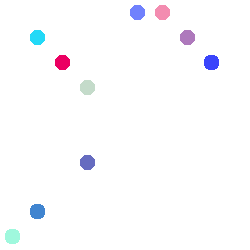

In [102]:
SimpleTest(Prioritized, 2, 60)